<a href="https://colab.research.google.com/github/ristars03/Analisis_Sentimen_BCF/blob/main/Analisis_Sentimen_BCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Implementasi Systen Analisis Sentimen Partnership Awards - Studi Kasus BCF


In [2]:
# 🔧 Install Library
!pip install numpy pandas matplotlib seaborn scikit-learn nltk tensorflow openpyxl

In [3]:
#Download file FastText Indo (cc.id.300.vec)

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz  # hasil akhir: cc.id.300.vec

--2025-06-15 16:50:38--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.48, 18.173.166.51, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   117MB/s    in 13s     

2025-06-15 16:50:50 (92.2 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



In [4]:
# 📚 Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# 📂 Upload & Load Dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_excel(next(iter(uploaded)))
data = data.dropna(subset=['Penilaian_Stakeholder', 'Label_Sentimen'])
data.head()

Saving FIXED_1000_DATASET_PARTNERSHIP_AWARDS.xlsx to FIXED_1000_DATASET_PARTNERSHIP_AWARDS.xlsx


,No.,Kategori,Deskripsi,Indikator,Mitra,Penilaian_Stakeholder,Label_Sentimen
0,1,The Most Applicants of University,Universitas dengan pendaftar terbanyak di prog...,Jumlah mahasiswa dari universitas terkait yang...,Universitas Negeri Semarang,"Terdapat 1286 Mahasiswa pendaftar, Universitas...",positif
1,2,The Most Applicants of University,Universitas dengan pendaftar terbanyak di prog...,Jumlah mahasiswa dari universitas terkait yang...,Universitas Brawijaya,"Terdapat 1274 Mahasiswa pendaftar, Universitas...",positif
2,3,The Most Applicants of University,Universitas dengan pendaftar terbanyak di prog...,Jumlah mahasiswa dari universitas terkait yang...,Universitas Sriwijaya,"Terdapat 1146 Mahasiswa pendaftar, Universitas...",positif
3,4,The Most Applicants of University,Universitas dengan pendaftar terbanyak di prog...,Jumlah mahasiswa dari universitas terkait yang...,Universitas Sumatera Utara,"Jumlah pendaftar dari USU cukup stabil, namun ...",netral
4,5,The Most Applicants of University,Universitas dengan pendaftar terbanyak di prog...,Jumlah mahasiswa dari universitas terkait yang...,Universitas Bakrie,"Sebagai universitas mitra, Bakrie menunjukkan ...",netral


In [6]:
# 🧹 Preprocessing Teks & Label
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

def normalize_label(label):
    label = str(label).strip().lower()
    if 'positif' in label:
        return 'positif'
    elif 'netral' in label:
        return 'netral'
    elif 'negatif' in label:
        return 'negatif'
    return None

data['Label_Sentimen'] = data['Label_Sentimen'].apply(normalize_label)
data = data.dropna(subset=['Label_Sentimen'])
data['cleaned_text'] = data['Penilaian_Stakeholder'].apply(clean_text)
data[['cleaned_text', 'Label_Sentimen']].head(10)

,cleaned_text,Label_Sentimen
0,mahasiswa pendaftar universita negeri semarang...,positif
1,mahasiswa pendaftar universita brawijaya menem...,positif
2,mahasiswa pendaftar universita sriwijaya menca...,positif
3,pendaftar usu stabil ditingkatkan partisipasi ...,netral
4,universita mitra bakri partisipasi pendaftar l...,netral
5,memiliki mahasiswa pendaftar unpad ekspektasi ...,negatif
6,pendaftar unair tergolong rendah diband univer...,negatif
7,pendaftar ui merata fakulta tertinggi kontribu...,netral
8,unj minat mahasiswa stabil program pendaftar k...,netral
9,pendaftar relatif rendah bidang vokasi relevan...,negatif


In [7]:
# 🔠 Encoding Label
encoder = LabelEncoder()
data['encoded_label'] = encoder.fit_transform(data['Label_Sentimen'])
X = data['cleaned_text']
y = data['encoded_label'].astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Kelas:", encoder.classes_)

Kelas: ['negatif' 'netral' 'positif']


In [8]:
# 📎 Tokenisasi dan Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

#Load vector FastText & buat matriks embedding
embedding_index = {}
with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Jumlah kata dalam FastText: {len(embedding_index)}")

#Buat embedding matrix untuk tokenizer
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(5000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Jumlah kata dalam FastText: 2000000


In [10]:
# 📌 MODEL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       313,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,500 (1.20 MB)

 Trainable params: 313,500 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 🔁 Training Model

history = model.fit(
    X_train_pad,
    y_train,
    epochs=25,
    validation_data=(X_test_pad, y_test),
    batch_size=32
)


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.3741 - loss: 1.0977 - val_accuracy: 0.3744 - val_loss: 1.0889
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 568ms/step - accuracy: 0.4031 - loss: 1.0644 - val_accuracy: 0.5172 - val_loss: 1.0063
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 566ms/step - accuracy: 0.6149 - loss: 0.8710 - val_accuracy: 0.5813 - val_loss: 0.9494
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - accuracy: 0.7709 - loss: 0.5301 - val_accuracy: 0.5911 - val_loss: 1.0372
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 573ms/step - accuracy: 0.8920 - loss: 0.2919 - val_accuracy: 0.6207 - val_loss: 1.1613
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 767ms/step - accuracy: 0.9453 - loss: 0.2167 - val_accuracy: 0.5468 - val_loss: 1.2488
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step - accuracy: 0.9724 - loss: 0.1138 - val_accuracy: 0.5862 - val_loss: 1.6616
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.9608 - loss: 0.1077 - val_accu

In [12]:
# 🔍 Prediksi dan Evaluasi
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report (BiLSTM):")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Classification Report (BiLSTM):
              precision    recall  f1-score   support

     negatif       0.66      0.49      0.56        63
      netral       0.57      0.62      0.59        63
     positif       0.62      0.70      0.66        77

    accuracy                           0.61       203
   macro avg       0.62      0.60      0.60       203
weighted avg       0.62      0.61      0.61       203



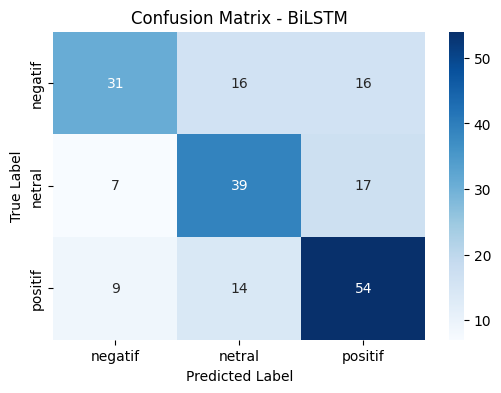

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BiLSTM")
plt.show()


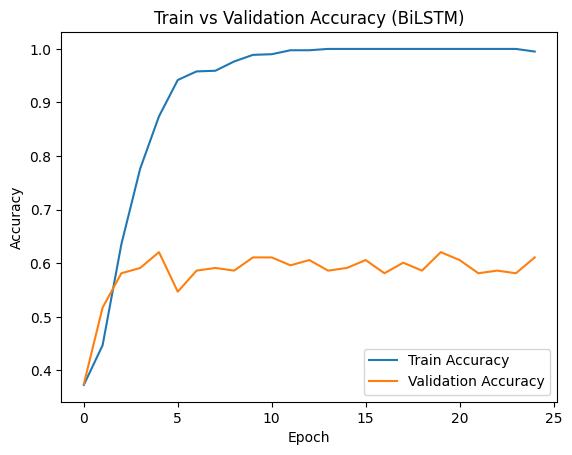

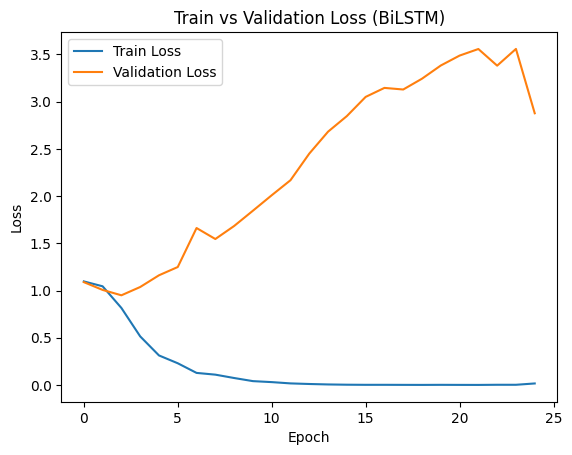

In [14]:
# Plot Akurasi

# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy (BiLSTM)')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (BiLSTM)')
plt.legend()
plt.show()


👩‍💻 DEMO SISTEM 👩‍💻

In [17]:
# Demo kalimat penilaian baru
penilaian_baru = [
    "Mitra sangat membantu dan aktif mendampingi mahasiswa.",
    "Tidak ada komunikasi dari pihak mitra selama kegiatan.",
    "Kinerjanya baik namun masih bisa ditingkatkan.",
    "Responsif dan profesional sepanjang program.",
    "Terjadi miskomunikasi yang menghambat proses.",
    "Mitra menerima masukan dengan terbuka.",
    "Kurang koordinasi saat implementasi program.",
    "Memberikan kontribusi nyata dalam pengembangan mahasiswa.",
    "Minim inisiatif dan kurang dukungan.",
    "Kerja sama sangat memuaskan dan lancar."
]

# Processing & Padding
penilaian_clean = [clean_text(k) for k in penilaian_baru]
penilaian_seq = tokenizer.texts_to_sequences(penilaian_clean)
penilaian_pad = pad_sequences(penilaian_seq, maxlen=maxlen, padding='post')

# Prediksi probabilitas dan label akhir
pred_prob = model.predict(penilaian_pad)
pred_label = np.argmax(pred_prob, axis=1)
pred_kelas = encoder.inverse_transform(pred_label)

# Tampilkan hanya label dan persentase confidence tertinggi
for i, (kalimat, probs) in enumerate(zip(penilaian_baru, pred_prob)):
    label_idx = np.argmax(probs)
    label = encoder.classes_[label_idx]
    confidence = probs[label_idx] * 100
    print(f"{i+1}. \"{kalimat}\" → {label} {confidence:.2f}%")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1. "Mitra sangat membantu dan aktif mendampingi mahasiswa." → positif 99.47%
2. "Tidak ada komunikasi dari pihak mitra selama kegiatan." → negatif 62.64%
3. "Kinerjanya baik namun masih bisa ditingkatkan." → netral 98.84%
4. "Responsif dan profesional sepanjang program." → positif 96.30%
5. "Terjadi miskomunikasi yang menghambat proses." → negatif 94.62%
6. "Mitra menerima masukan dengan terbuka." → netral 99.94%
7. "Kurang koordinasi saat implementasi program." → netral 67.43%
8. "Memberikan kontribusi nyata dalam pengembangan mahasiswa." → negatif 78.65%
9. "Minim inisiatif dan kurang dukungan." → negatif 99.09%
10. "Kerja sama sangat memuaskan dan lancar." → positif 80.12%
